In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
from scipy import stats
from tqdm import tqdm

# Set the Optuna logger to output only WARNING and higher levels
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

/Users/user/anaconda3/envs/GIGACOW/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'Int64',
    'YearSeason': 'str',
    'LactationNumber': 'Int64',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'HeatLoad': 'float',
    'MeanTHI_adj': 'float',
    'CumulativeHeatLoad': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/HeatApproachYieldDataTest.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,HeatLoad,CumulativeHeatLoad
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8,3,2022-2,15.22,NaN,...,NaN,1.820438,0,0,0,0,9.912500,50.478673,-10.521327,0.000000
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8,4,2022-2,18.96,15.22,...,0.215311,1.589745,0,0,0,0,10.066667,53.841648,-7.158352,0.000000
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8,5,2022-2,22.64,18.96,...,0.177389,1.894598,0,1,0,0,10.466667,52.935959,-8.064041,0.000000
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8,6,2022-2,26.49,22.64,...,0.163049,2.877443,0,0,0,0,11.183333,52.872112,-8.127888,0.000000
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8,7,2022-3,33.61,26.49,...,0.273358,7.563598,0,1,0,0,12.704167,56.056547,-4.943453,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576066,2024-08-09,f454e660,SE-f454e660-810,1020,99 Korsning/obestämbar ras,1,365,2024-3,37.53,31.36,...,0.168909,1.001508,1,1,0,0,18.650000,62.298109,1.298109,84.512273
576067,2024-08-10,f454e660,SE-f454e660-810,1021,99 Korsning/obestämbar ras,1,365,2024-3,36.48,37.53,...,-0.028745,-0.048492,1,1,0,0,18.308333,54.687773,-6.312227,71.887820
576068,2024-08-11,f454e660,SE-f454e660-810,1022,99 Korsning/obestämbar ras,1,365,2024-3,34.76,36.48,...,-0.047087,-1.768492,1,1,0,0,17.841667,55.974084,-5.025916,61.835988
576069,2024-08-12,f454e660,SE-f454e660-810,1023,99 Korsning/obestämbar ras,1,365,2024-3,38.06,34.76,...,0.090340,1.531508,1,1,0,0,17.516667,60.115007,-0.884993,60.066002


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'HeatLoad' is float type
daily_farm_data['HeatLoad'] = daily_farm_data['HeatLoad'].astype(float)

# Define a threshold of 0 (unscaled)
threshold_heatload = 0

# Save unscaled HeatLoad for threshold comparison
daily_farm_data['UnscaledHeatLoad'] = daily_farm_data['HeatLoad']

# Scale the 'HeatLoad' feature (for the model)
scaler = StandardScaler()
daily_farm_data['HeatLoad'] = scaler.fit_transform(daily_farm_data[['HeatLoad']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change based on HeatLoad threshold
def fit_xgboost_and_calculate_yield_change(data, feature, threshold):
    cow_ids = data['SE_Number'].unique()
    
    # Wrap the cow iteration loop in tqdm to show a progress bar
    for cow in tqdm(cow_ids, desc="Processing cows", unit="cow"):
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        test_data['PredictedYield'] = best_model.predict(test_data[[feature]])
        
        # Initialize avg_yield_low_heatload and avg_yield_high_heatload to None
        avg_yield_low_heatload = None
        avg_yield_high_heatload = None
        
        # Calculate the reduction in yield for HeatLoad values above the threshold using unscaled HeatLoad
        low_heatload_data = test_data[test_data['UnscaledHeatLoad'] <= threshold]
        high_heatload_data = test_data[test_data['UnscaledHeatLoad'] > threshold]
        
        # Mean predicted yield for low and high HeatLoad values
        if len(low_heatload_data) > 0:
            avg_yield_low_heatload = low_heatload_data['PredictedYield'].mean()
        
        if len(high_heatload_data) > 0:
            avg_yield_high_heatload = high_heatload_data['PredictedYield'].mean()
        
        # Calculate reduction as a percentage, if both low and high HeatLoad data are available
        if avg_yield_low_heatload is not None and avg_yield_high_heatload is not None:
            reduction = ((avg_yield_low_heatload - avg_yield_high_heatload) / avg_yield_low_heatload) * 100
        else:
            reduction = None  # Not enough data to calculate
        
        # Store results
        results.append({
            'SE_Number': cow,
            'Yield Low HeatLoad': avg_yield_low_heatload,
            'Yield High HeatLoad': avg_yield_high_heatload,
            'Reduction (%)': reduction
        })
    
    return results

# Use 'HeatLoad' as the feature
selected_feature = 'HeatLoad'

# Fit the model and calculate yield changes for all cows using the HeatLoad threshold of 0
yield_changes = fit_xgboost_and_calculate_yield_change(daily_farm_data, selected_feature, threshold_heatload)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes)
results_df

Processing cows: 100%|██████████| 141/141 [2:47:50<00:00, 71.42s/cow] 


,SE_Number,Yield Low HeatLoad,Yield High HeatLoad,Reduction (%)
0,SE-064c0cec-1189,1.009034,1.009004,0.002906
1,SE-30dc5787-1389,1.004845,1.000200,0.462307
2,SE-30dc5787-1396,1.010833,0.948592,6.157380
3,SE-a624fb9a-1039,1.009386,1.005627,0.372431
4,SE-a624fb9a-1162,1.006279,1.004778,0.149207
...,...,...,...,...
136,SE-a624fb9a-1267,1.005140,0.992203,1.287068
137,SE-a624fb9a-1274,0.998379,1.024707,-2.637097
138,SE-a624fb9a-1324,1.017428,1.006200,1.103634
139,SE-a624fb9a-1428,1.006379,1.006419,-0.004004


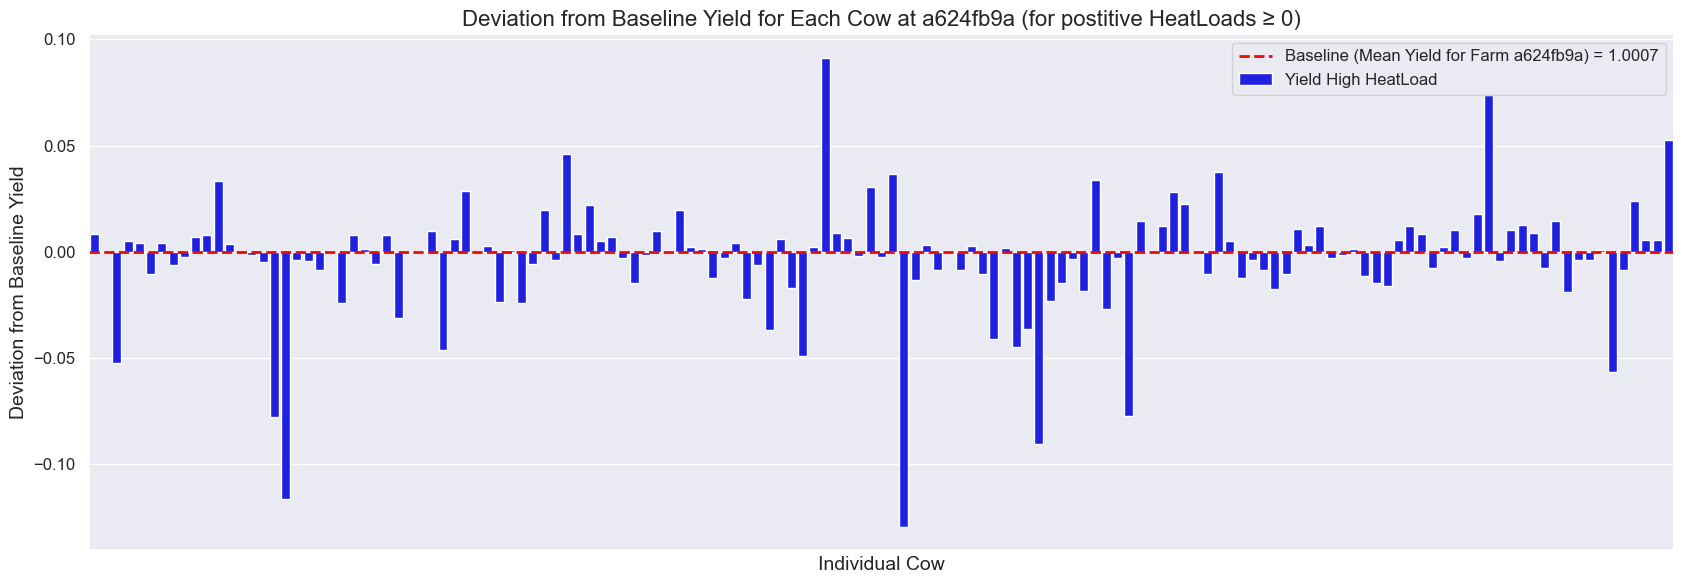

In [4]:
# Calculate the baseline (mean yield for the farm)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield High HeatLoad'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield High HeatLoad')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm}) = {baseline_yield_change:.4f}')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.title(f'Deviation from Baseline Yield for Each Cow at {farm} (for postitive HeatLoads ≥ 0)', fontsize=16)

# Hide the x-axis labels (cow IDs) if there are many cows
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
# # Calculate the baseline (mean yield change)
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# # Calculate deviations from the baseline
# results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# # Plotting
# plt.figure(figsize=(17, 6))
# sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# # Add baseline line
# plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm} on Heatstress days = {baseline_yield_change:.4f})')

# # Formatting the plot
# plt.xlabel('Individual Cow', fontsize=14)
# plt.ylabel('Yield HeatStress', fontsize=14)
# plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.legend(fontsize=12)
# plt.yticks(fontsize=12)

# plt.tight_layout()
# plt.show()

## Farm 5c06d92d

In [6]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'HeatLoad' is float type
daily_farm_data['HeatLoad'] = daily_farm_data['HeatLoad'].astype(float)

# Define a threshold of 0 (unscaled)
threshold_heatload = 0

# Save unscaled HeatLoad for threshold comparison
daily_farm_data['UnscaledHeatLoad'] = daily_farm_data['HeatLoad']

# Scale the 'HeatLoad' feature (for the model)
scaler = StandardScaler()
daily_farm_data['HeatLoad'] = scaler.fit_transform(daily_farm_data[['HeatLoad']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change based on HeatLoad threshold
def fit_xgboost_and_calculate_yield_change(data, feature, threshold):
    cow_ids = data['SE_Number'].unique()
    
    # Wrap the cow iteration loop in tqdm to show a progress bar
    for cow in tqdm(cow_ids, desc="Processing cows", unit="cow"):
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        test_data['PredictedYield'] = best_model.predict(test_data[[feature]])
        
        # Initialize avg_yield_low_heatload and avg_yield_high_heatload to None
        avg_yield_low_heatload = None
        avg_yield_high_heatload = None
        
        # Calculate the reduction in yield for HeatLoad values above the threshold using unscaled HeatLoad
        low_heatload_data = test_data[test_data['UnscaledHeatLoad'] <= threshold]
        high_heatload_data = test_data[test_data['UnscaledHeatLoad'] > threshold]
        
        # Mean predicted yield for low and high HeatLoad values
        if len(low_heatload_data) > 0:
            avg_yield_low_heatload = low_heatload_data['PredictedYield'].mean()
        
        if len(high_heatload_data) > 0:
            avg_yield_high_heatload = high_heatload_data['PredictedYield'].mean()
        
        # Calculate reduction as a percentage, if both low and high HeatLoad data are available
        if avg_yield_low_heatload is not None and avg_yield_high_heatload is not None:
            reduction = ((avg_yield_low_heatload - avg_yield_high_heatload) / avg_yield_low_heatload) * 100
        else:
            reduction = None  # Not enough data to calculate
        
        # Store results
        results.append({
            'SE_Number': cow,
            'Yield Low HeatLoad': avg_yield_low_heatload,
            'Yield High HeatLoad': avg_yield_high_heatload,
            'Reduction (%)': reduction
        })
    
    return results

# Use 'HeatLoad' as the feature
selected_feature = 'HeatLoad'

# Fit the model and calculate yield changes for all cows using the HeatLoad threshold of 0
yield_changes = fit_xgboost_and_calculate_yield_change(daily_farm_data, selected_feature, threshold_heatload)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes)
results_df

Processing cows: 100%|██████████| 478/478 [7:58:39<00:00, 60.08s/cow]  


,SE_Number,Yield Low HeatLoad,Yield High HeatLoad,Reduction (%)
0,SE-5c06d92d-2055,1.010532,1.010585,-0.005214
1,SE-5c06d92d-2058,1.002364,1.000815,0.154535
2,SE-5c06d92d-2254,0.997009,0.990437,0.659172
3,SE-5c06d92d-2283,1.006165,1.004661,0.149390
4,SE-5c06d92d-2333,1.007447,1.016759,-0.924356
...,...,...,...,...
473,SE-5c06d92d-3441,1.002782,1.003146,-0.036294
474,SE-5c06d92d-3443,1.004046,1.006738,-0.268161
475,SE-5c06d92d-3485,1.008346,1.027852,-1.934441
476,SE-5c06d92d-3511,0.994884,0.995241,-0.035821


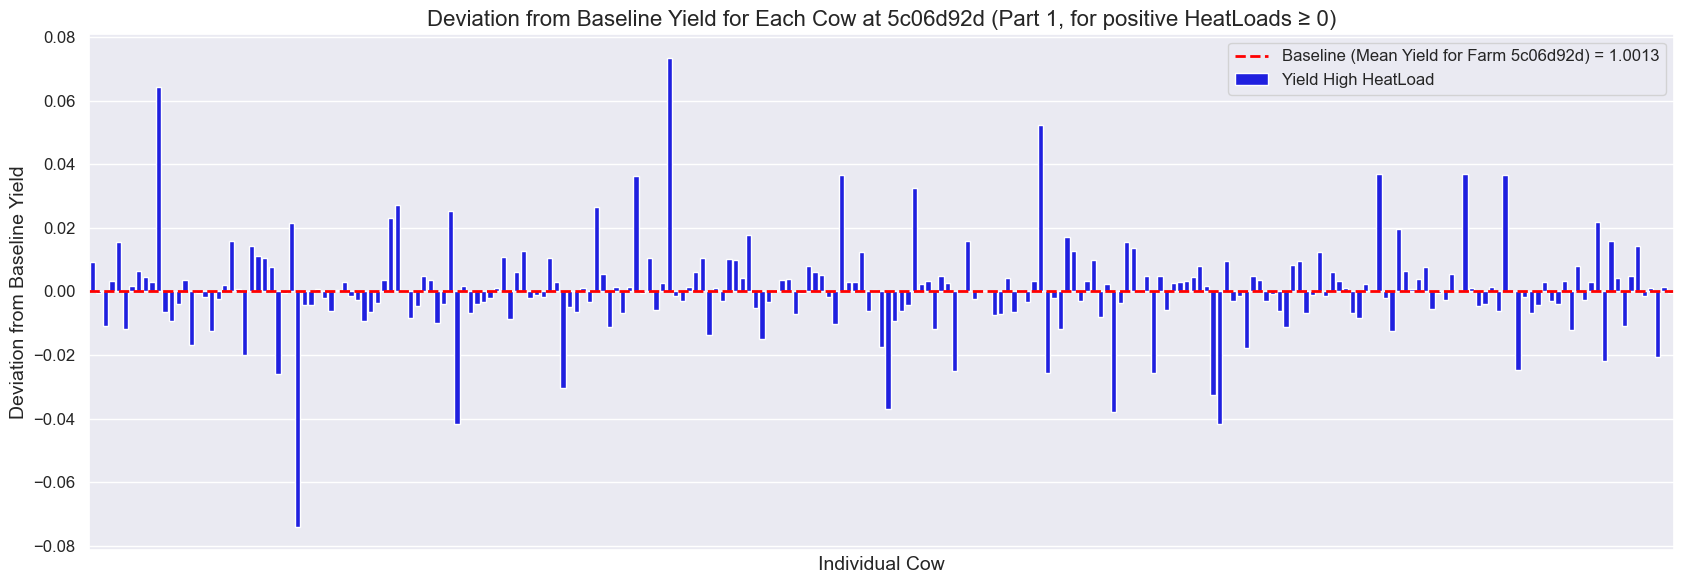

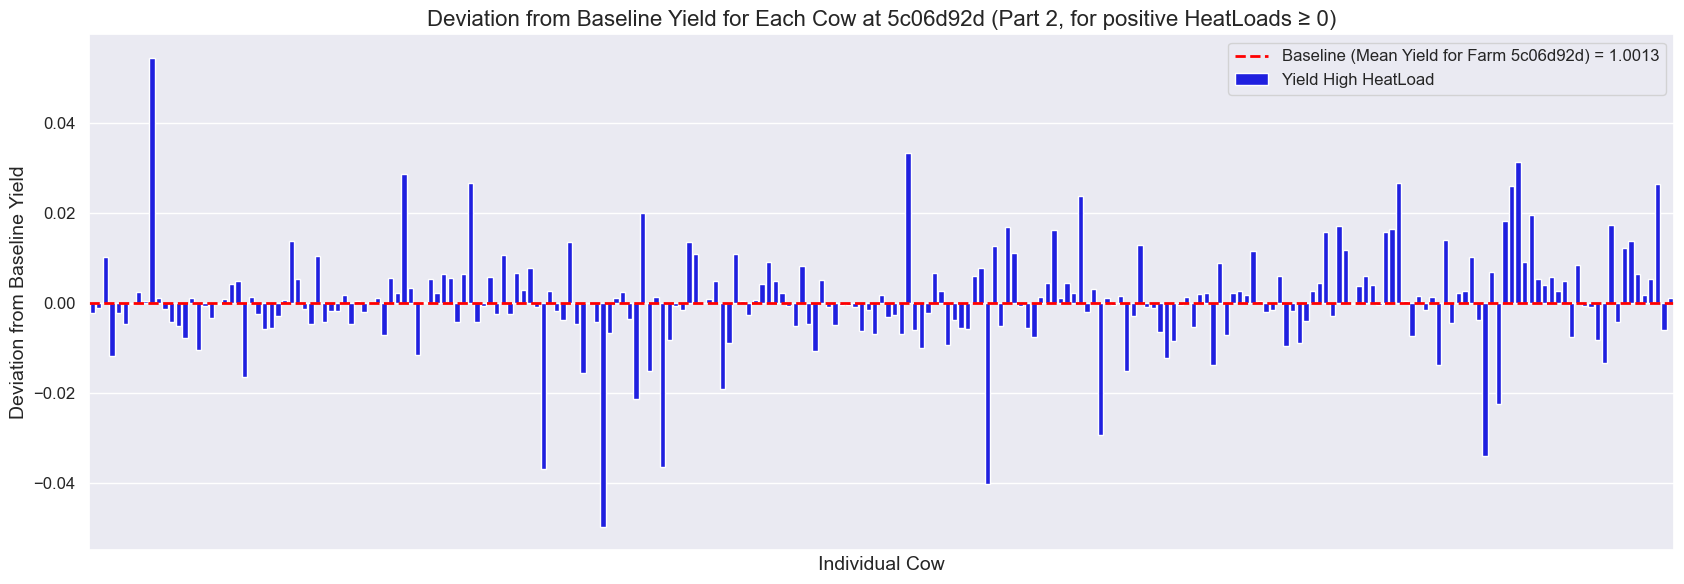

In [7]:
# Calculate the baseline (mean yield for the farm)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for high temperatures
results_df['Deviation from Baseline'] = results_df['Yield High HeatLoad'] - baseline_yield_change

# Determine the midpoint to split the data (if there are many cows)
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half (Part 1)
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield High HeatLoad')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm}) = {baseline_yield_change:.4f}')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.title(f'Deviation from Baseline Yield for Each Cow at {farm} (Part 1, for positive HeatLoads ≥ 0)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half (Part 2)
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield High HeatLoad')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm}) = {baseline_yield_change:.4f}')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.title(f'Deviation from Baseline Yield for Each Cow at {farm} (Part 2, for positive HeatLoads ≥ 0)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
# # Calculate the baseline (mean yield change)
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# # Calculate deviations from the baseline
# results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# # Determine the midpoint to split the data
# midpoint = len(results_df) // 2

# # Split the data into two halves
# first_half = results_df.iloc[:midpoint]
# second_half = results_df.iloc[midpoint:]

# # Plotting for the first half
# plt.figure(figsize=(17, 6))
# sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
# plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
# plt.xlabel('Individual Cow', fontsize=14)
# plt.ylabel('Deviation from Baseline', fontsize=14)
# plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

# # Plotting for the second half
# plt.figure(figsize=(17, 6))
# sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
# plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
# plt.xlabel('Individual Cow', fontsize=14)
# plt.ylabel('Deviation from Baseline', fontsize=14)
# plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

## Farm 752efd72

In [9]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'HeatLoad' is float type
daily_farm_data['HeatLoad'] = daily_farm_data['HeatLoad'].astype(float)

# Define a threshold of 0 (unscaled)
threshold_heatload = 0

# Save unscaled HeatLoad for threshold comparison
daily_farm_data['UnscaledHeatLoad'] = daily_farm_data['HeatLoad']

# Scale the 'HeatLoad' feature (for the model)
scaler = StandardScaler()
daily_farm_data['HeatLoad'] = scaler.fit_transform(daily_farm_data[['HeatLoad']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change based on HeatLoad threshold
def fit_xgboost_and_calculate_yield_change(data, feature, threshold):
    cow_ids = data['SE_Number'].unique()
    
    # Wrap the cow iteration loop in tqdm to show a progress bar
    for cow in tqdm(cow_ids, desc="Processing cows", unit="cow"):
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        test_data['PredictedYield'] = best_model.predict(test_data[[feature]])
        
        # Initialize avg_yield_low_heatload and avg_yield_high_heatload to None
        avg_yield_low_heatload = None
        avg_yield_high_heatload = None
        
        # Calculate the reduction in yield for HeatLoad values above the threshold using unscaled HeatLoad
        low_heatload_data = test_data[test_data['UnscaledHeatLoad'] <= threshold]
        high_heatload_data = test_data[test_data['UnscaledHeatLoad'] > threshold]
        
        # Mean predicted yield for low and high HeatLoad values
        if len(low_heatload_data) > 0:
            avg_yield_low_heatload = low_heatload_data['PredictedYield'].mean()
        
        if len(high_heatload_data) > 0:
            avg_yield_high_heatload = high_heatload_data['PredictedYield'].mean()
        
        # Calculate reduction as a percentage, if both low and high HeatLoad data are available
        if avg_yield_low_heatload is not None and avg_yield_high_heatload is not None:
            reduction = ((avg_yield_low_heatload - avg_yield_high_heatload) / avg_yield_low_heatload) * 100
        else:
            reduction = None  # Not enough data to calculate
        
        # Store results
        results.append({
            'SE_Number': cow,
            'Yield Low HeatLoad': avg_yield_low_heatload,
            'Yield High HeatLoad': avg_yield_high_heatload,
            'Reduction (%)': reduction
        })
    
    return results

# Use 'HeatLoad' as the feature
selected_feature = 'HeatLoad'

# Fit the model and calculate yield changes for all cows using the HeatLoad threshold of 0
yield_changes = fit_xgboost_and_calculate_yield_change(daily_farm_data, selected_feature, threshold_heatload)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes)
results_df

Processing cows: 100%|██████████| 403/403 [6:50:55<00:00, 61.18s/cow]   


,SE_Number,Yield Low HeatLoad,Yield High HeatLoad,Reduction (%)
0,SE-752efd72-0001,1.009634,0.980387,2.896826
1,SE-752efd72-0002,0.986630,1.060943,-7.532076
2,SE-752efd72-0008,0.993945,1.016704,-2.289803
3,SE-752efd72-0010,1.003513,1.002062,0.144582
4,SE-752efd72-0011,0.998042,0.998060,-0.001762
...,...,...,...,...
398,SE-752efd72-0345,1.006166,1.001899,0.424035
399,SE-752efd72-0450,1.003796,0.993978,0.978089
400,SE-752efd72-0468,1.005779,1.005684,0.009458
401,SE-752efd72-0469,1.000243,1.000163,0.007973


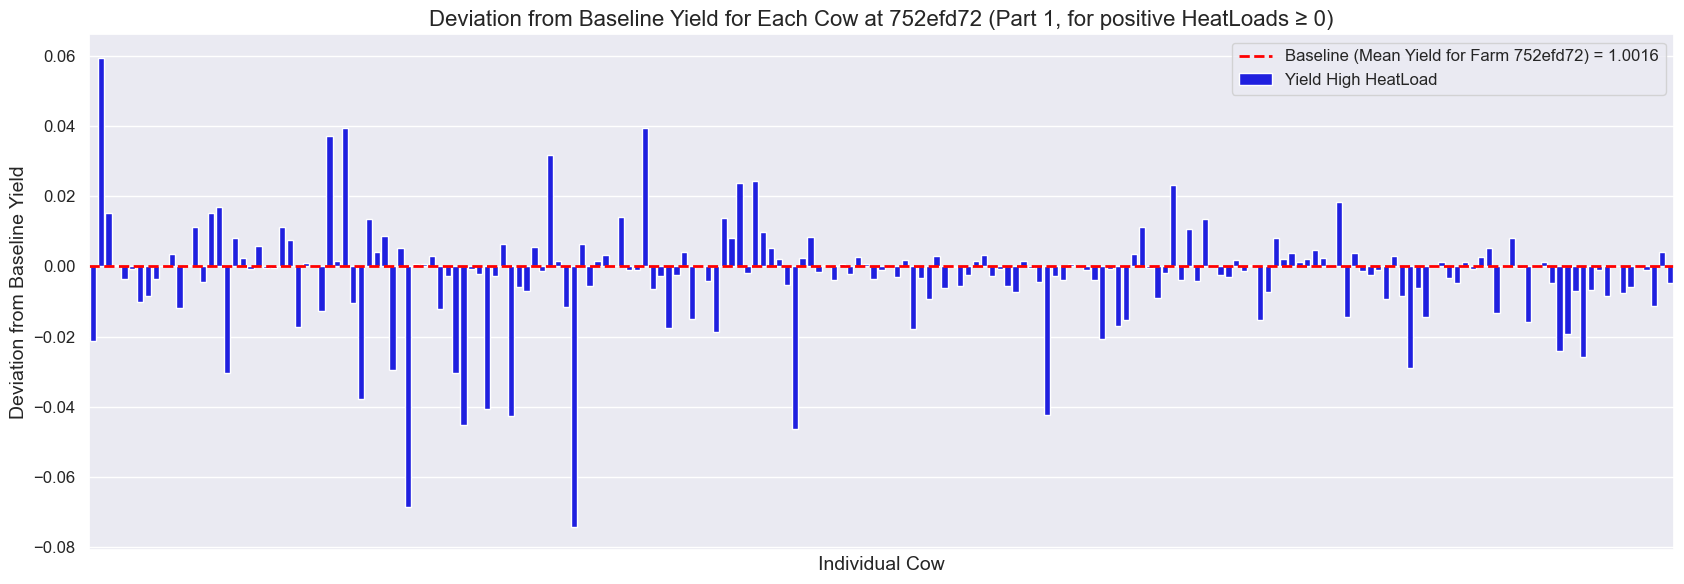

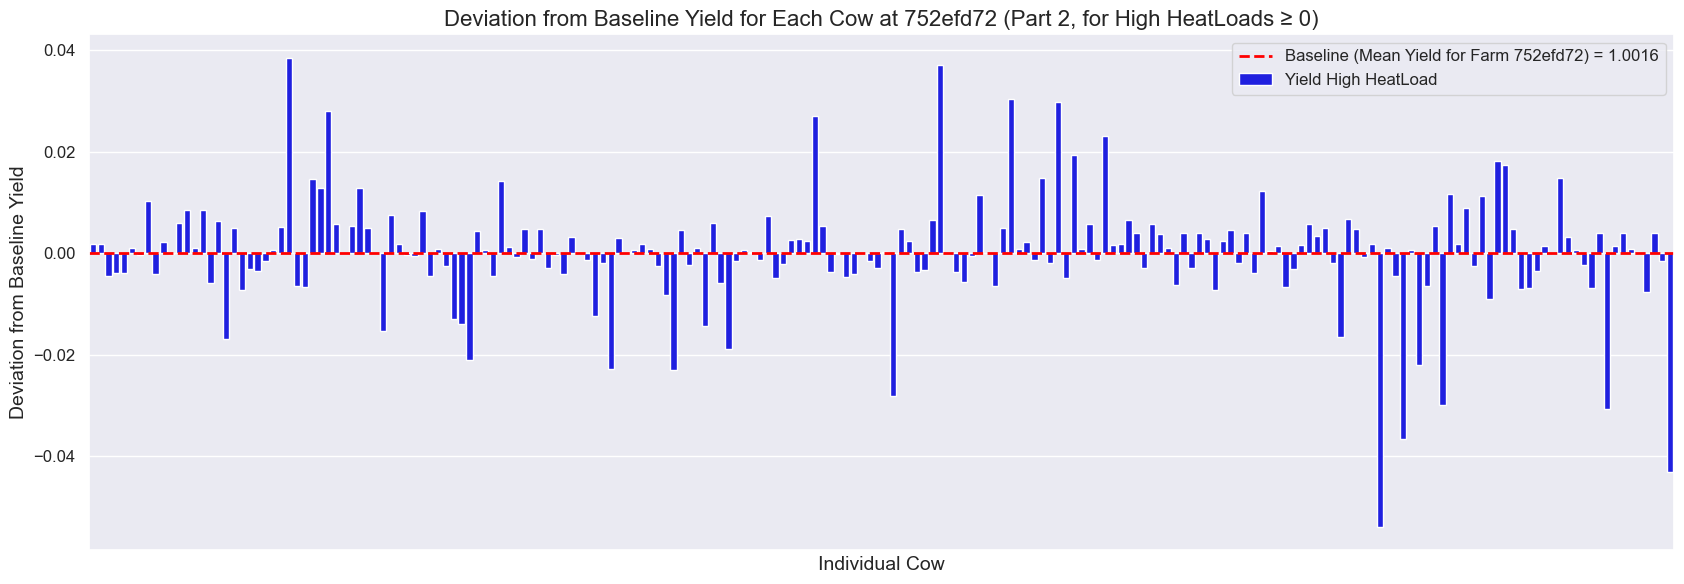

In [10]:
# Calculate the baseline (mean yield for the farm)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for high temperatures
results_df['Deviation from Baseline'] = results_df['Yield High HeatLoad'] - baseline_yield_change

# Determine the midpoint to split the data (if there are many cows)
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half (Part 1)
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield High HeatLoad')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm}) = {baseline_yield_change:.4f}')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.title(f'Deviation from Baseline Yield for Each Cow at {farm} (Part 1, for positive HeatLoads ≥ 0)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half (Part 2)
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield High HeatLoad')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm}) = {baseline_yield_change:.4f}')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.title(f'Deviation from Baseline Yield for Each Cow at {farm} (Part 2, for High HeatLoads ≥ 0)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
# # Calculate the baseline (mean yield change)
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# # Calculate deviations from the baseline
# results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# # Determine the midpoint to split the data
# midpoint = len(results_df) // 2

# # Split the data into two halves
# first_half = results_df.iloc[:midpoint]
# second_half = results_df.iloc[midpoint:]

# # Plotting for the first half
# plt.figure(figsize=(17, 6))
# sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
# plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
# plt.xlabel('Individual Cow', fontsize=14)
# plt.ylabel('Deviation from Baseline', fontsize=14)
# plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

# # Plotting for the second half
# plt.figure(figsize=(17, 6))
# sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
# plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
# plt.xlabel('Individual Cow', fontsize=14)
# plt.ylabel('Deviation from Baseline', fontsize=14)
# plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

## Farm f454e660

In [12]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'HeatLoad' is float type
daily_farm_data['HeatLoad'] = daily_farm_data['HeatLoad'].astype(float)

# Define a threshold of 0 (unscaled)
threshold_heatload = 0

# Save unscaled HeatLoad for threshold comparison
daily_farm_data['UnscaledHeatLoad'] = daily_farm_data['HeatLoad']

# Scale the 'HeatLoad' feature (for the model)
scaler = StandardScaler()
daily_farm_data['HeatLoad'] = scaler.fit_transform(daily_farm_data[['HeatLoad']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change based on HeatLoad threshold
def fit_xgboost_and_calculate_yield_change(data, feature, threshold):
    cow_ids = data['SE_Number'].unique()
    
    # Wrap the cow iteration loop in tqdm to show a progress bar
    for cow in tqdm(cow_ids, desc="Processing cows", unit="cow"):
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        test_data['PredictedYield'] = best_model.predict(test_data[[feature]])
        
        # Initialize avg_yield_low_heatload and avg_yield_high_heatload to None
        avg_yield_low_heatload = None
        avg_yield_high_heatload = None
        
        # Calculate the reduction in yield for HeatLoad values above the threshold using unscaled HeatLoad
        low_heatload_data = test_data[test_data['UnscaledHeatLoad'] <= threshold]
        high_heatload_data = test_data[test_data['UnscaledHeatLoad'] > threshold]
        
        # Mean predicted yield for low and high HeatLoad values
        if len(low_heatload_data) > 0:
            avg_yield_low_heatload = low_heatload_data['PredictedYield'].mean()
        
        if len(high_heatload_data) > 0:
            avg_yield_high_heatload = high_heatload_data['PredictedYield'].mean()
        
        # Calculate reduction as a percentage, if both low and high HeatLoad data are available
        if avg_yield_low_heatload is not None and avg_yield_high_heatload is not None:
            reduction = ((avg_yield_low_heatload - avg_yield_high_heatload) / avg_yield_low_heatload) * 100
        else:
            reduction = None  # Not enough data to calculate
        
        # Store results
        results.append({
            'SE_Number': cow,
            'Yield Low HeatLoad': avg_yield_low_heatload,
            'Yield High HeatLoad': avg_yield_high_heatload,
            'Reduction (%)': reduction
        })
    
    return results

# Use 'HeatLoad' as the feature
selected_feature = 'HeatLoad'

# Fit the model and calculate yield changes for all cows using the HeatLoad threshold of 0
yield_changes = fit_xgboost_and_calculate_yield_change(daily_farm_data, selected_feature, threshold_heatload)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes)
results_df

Processing cows: 100%|██████████| 191/191 [3:13:32<00:00, 60.80s/cow]  


,SE_Number,Yield Low HeatLoad,Yield High HeatLoad,Reduction (%)
0,SE-a2bab923-5680-5,0.997256,1.003912,-0.667425
1,SE-f454e660-0139,1.000764,1.001196,-0.043133
2,SE-f454e660-0335,1.005891,0.972077,3.361610
3,SE-f454e660-0412,0.993027,1.020141,-2.730364
4,SE-f454e660-0465,1.016854,0.936275,7.924370
...,...,...,...,...
186,SE-f454e660-747,0.996535,0.998620,-0.209198
187,SE-f454e660-750,1.006820,1.026185,-1.923330
188,SE-f454e660-787,0.990554,0.994468,-0.395180
189,SE-f454e660-799,0.988622,1.061569,-7.378676


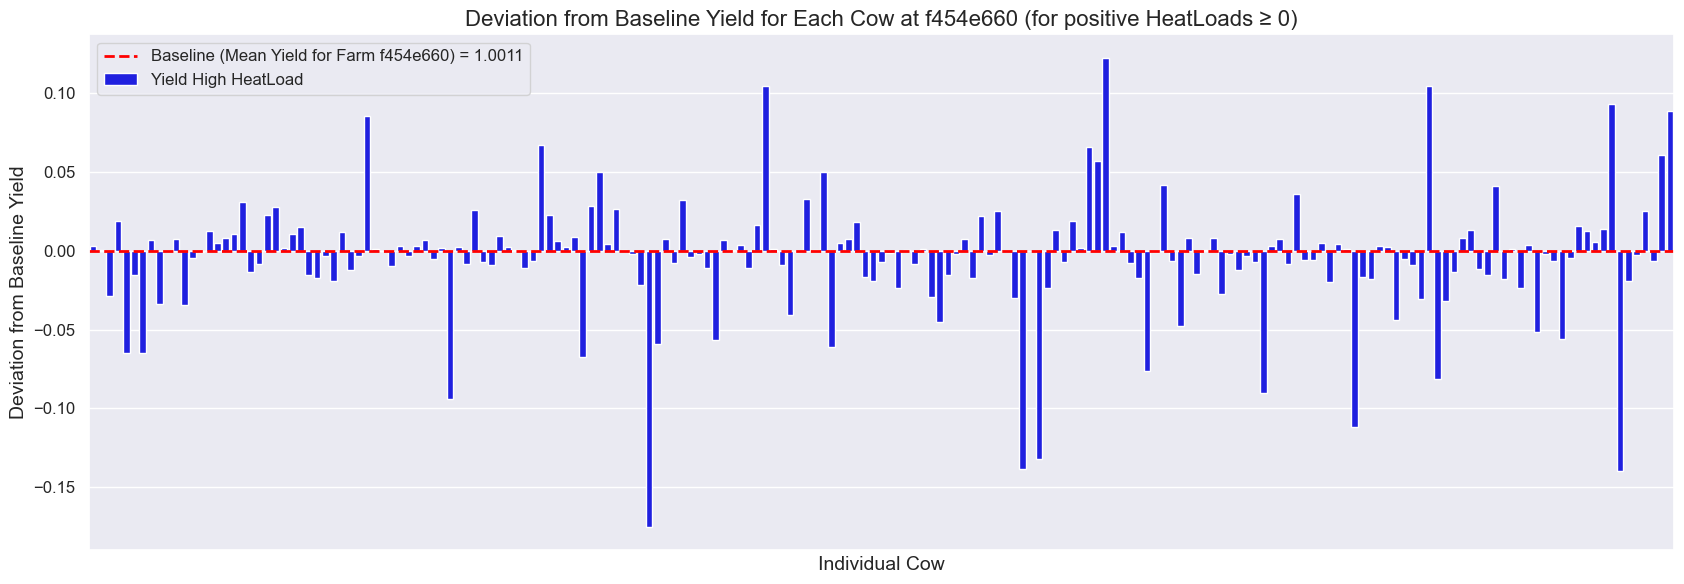

In [13]:
# Calculate the baseline (mean yield for the farm)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield High HeatLoad'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield High HeatLoad')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm}) = {baseline_yield_change:.4f}')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.title(f'Deviation from Baseline Yield for Each Cow at {farm} (for positive HeatLoads ≥ 0)', fontsize=16)

# Hide the x-axis labels (cow IDs) if there are many cows
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [14]:
# # Calculate the baseline (mean yield change)
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# # Calculate deviations from the baseline
# results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# # Plotting
# plt.figure(figsize=(17, 6))
# sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# # Add baseline line
# plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# # Formatting the plot
# plt.xlabel('Individual Cow', fontsize=14)
# plt.ylabel('Yield HeatStress', fontsize=14)
# plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.legend(fontsize=12)
# plt.yticks(fontsize=12)

# plt.tight_layout()
# plt.show()